# MsPASS Short Course
## Session 1:   Overview
The purpose of this notebook is to provide a overview of the main features of MsPASS that we will
be covering in this course.  The notebook will lead you through the following steps:

1.  We will assemble a small data set from the IRIS DMC using either web services.   That process
    is aimed to build a local copy of the data to drive later processing, which is currently the recommended way 
    of running MsPASS. 
2.  We will run a set of common preprocessing steps.  These are a mix of database operations to 
    associate the right source and receiver metadata with each waveform and some lightweight waveform 
    manipulation to window data around a theoretical P time and bundle the data into three-component
    data objects.  
3.  We illustrate how easy it is to translate a serial workflow to a parallel workflow.  The example we 
    will compute is a set of standard receiver functions computing with the multitaper method. 

This notebook assumes you already have docker running, launched the MsPASS container, 
and you are running this notebook by connecting to the notebook server running on the container.  
You won't be reading a local copy unless that is true.
## Preprocessing:  assembling a working data set for this session
### Source selection
We are going to be working with the reflection seismology equivalent of a shot gather.  
For this session we will be working with a single magnitude 7.0 aftershock of the 2012 
Tohoku earthquake recorded by the USArray.

The first step is to pull the detail source information and save it our database.

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client=Client("IRIS")
t0=UTCDateTime('2011-04-07T14:32:44.100000Z')
starttime=t0-3600.0
endtime=t0+3600.0
lat0=38.3
lon0=142.5
minlat=lat0-3.0
maxlat=lat0+3.0
minlon=lon0-3.0
maxlon=lon0+3.0
minmag=6.5

cat=client.get_events(starttime=starttime,endtime=endtime,
        minlatitude=minlat,minlongitude=minlon,
        maxlatitude=maxlat,maxlongitude=maxlon,
        minmagnitude=minmag)
print(cat)

1 Event(s) in Catalog:
2011-04-07T14:32:44.100000Z | +38.251, +141.730 | 7.1 MW


Note the above is a pure obspy python script.   They define a *Catalog* object they use to store event information.  A *Catalog* is more or less an image of the quakeml format data delivered by FDSN web service calls that the IRIS DMC just responded to when you ran that box.  The next box makes the first use of a MsPASS.  This short script saves the *Catalog* we just created into the MsPASS database system (based on MongoDB):

In [2]:
from mspasspy.db.database import Database
from mspasspy.db.client import DBClient
dbclient=DBClient()
db=Database(dbclient,'shortcourse')

In [3]:
n=db.save_catalog(cat)
print('number of event entries saved in source collection=',n)

number of event entries saved in source collection= 1


#### Select stations and download station metadata
We now need to do parallel procedure to retrieve any relevant station information.  For this exercise we are going to use only data from the USArray "TA" stations, which have the SEED net code "TA".   As with sources we use obspy's web service client, but in this case we retrieve station data:

In [4]:
inv=client.get_stations(network='TA',starttime=starttime,endtime=endtime,
                        format='xml',channel='BH?',level='response')
net=inv.networks
x=net[0]
sta=x.stations
print("Number of stations retrieved=",len(sta))
print(inv)

Number of stations retrieved= 433
Inventory created at 2021-07-29T20:05:49.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-04-07...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			TA
		Stations (433):
			TA.034A (Hebronville, TX, USA)
			TA.035A (Encino, TX, USA)
			TA.035Z (Hargill, TX, USA)
			TA.109C (Camp Elliot, Miramar, CA, USA)
			TA.121A (Cookes Peak, Deming, NM, USA)
			TA.133A (Hamilton Ranch, Breckenridge, TX, USA)
			TA.134A (White-Moore Ranch, Lipan, TX, USA)
			TA.135A (Vickery Place, Crowley, TX, USA)
			TA.136A (Ennis, TX, USA)
			TA.137A (Heron Place, Grand Saline, TX, USA)
			TA.138A (Matatall Enterprise, Big Sandy, TX, USA)
			TA.139A (Bunkhouse Ranch, Marshall, TX, USA)
			TA.140A (Cam and Jess, Hughton, LA, USA)
			TA.141A (Papa Simpson, Farm, Arcadia, LA, USA)
			TA.142A (Monroe, LA, USA)
			TA.143A (Socs Landing, Pioneer, LA, USA)
			TA.144A (Alexan

Similar to the source data, obspy's web service client creates an image of the returned stationxml data that they call an *Inventory*.   We next use a parallel, simple database method to save this python object to our working database:

In [5]:
ret=db.save_inventory(inv)

Database.save_inventory processing summary:
Number of site records processed= 434
number of site records saved= 434
number of channel records processed= 1308
number of channel records saved= 1302


In this case, this function produced only a summary of what it wrote.  In later sessions we will help you understand more about this output.  There is a verbose mode we turned off that would have told us that the reason the last two lines have a different number is that web services returned 6 duplicates.   As those of you who have worked with a lot of IRIS data probably know there are a lot of station metadata inconsistencies in what you get from web services.   Anyone who has had to deal with experimental data totally understand why, but it is a truth and a never ending job people at DMC and other data centers face.   The point for this session is that save_inventory always checks for duplicates and will silently skip them unless the verbose option is turned on.  If running verbose the duplicates will still be skipped, but you will get an error message.  Although we skipped it here, in general we recommend running save_inventory in verbose mode to make sure you are aware of any warts in the station metadata. 

### Load waveform data - fast option with miniseed file
This tutorial is standalone if you skip this section and go to the next section that uses FDSN web services to download waveform data. If you run that block you will quickly witness the fundamental problem of the current performance of web services for waveform data; the time to do the download is minutes even for the modest one event tutorial data we are using here.   For those running this tutorial during the SAGE-GAGE workshop in 2021 we will give you a URL that you can use to download a miniseed file that can build the same data set as the web service block below.   

Follow these steps to get that data and load them onto your local system:
1.  Download the tar file from the URL we will supply.
2.  With a terminal and the unix shell, cd to the directory from which you launched this notebook.
3.  Run tar using the absolute path to the file you download (typically "Downloads" today, but can be configuration dependent.).  i.e. you run something like:  `tar xvf absolute_path` where absolute path is that (in unix the file name begins with "/" and windows "\"). 
4.  That should create a directory called "./wf" in the current directory with bunch of miniseed files in it.  Then run this to load these data into the MsPASS database:

In [6]:
import os
with os.scandir('./wf') as entries:
    count=0
    for entry in entries:
        if entry.is_file():
            filename='./wf'+'/'+entry.name
            db.index_mseed_file(filename)
            count += 1
print('Number of files processed=',count)

Number of files processed= 1287


Note the loop builds only an index to the waveform files. For Antelope user's that loop is functionally similar to running miniseed2db.  We will dig into this a bit more deeply in session 2.

### Download waveform data:  web service option for use outside short course
You can use this section as an alternative to the one immediately above if you are working this tutorial at a time other than with the instructors of the 2021 short course.  Rather than download files here we use obspy's webservice client to get the same data the students in the class received by taking a tar file apart. 

Be aware this will take several minutes even for this tiny data set and with decent internet connection.  Read forward or take the opportunity for a coffee break - about the time it takes for this typically to complete.

In [7]:
from mspasspy.util.converter import Trace2TimeSeries
import os   # need this for directory handling
from obspy import UTCDateTime
import time
# Set this True if you want to run this procedure to download the data with web services
# We use this logic as it allows the entire notebook to be run in a single pass if desired
# Particularly useful for testing
RunME=False
if RunME:
    # We need to recreate a db handle to deal using this incantation to get
    # around a seed issue that is deep in the weeds.  We'll plan to discuss this later
    db=Database(dbclient,'shortcourse',db_schema='mspass_lite.yaml', md_schema='mspass_lite.yaml')
    dbsource=db.source
    doc=dbsource.find_one()   
    origin_time=doc['time']
    # We need the ObjectId of the source to provide a cross reference to link our 
    # waveform data to the right source.  Better to do this now than later as association 
    # can be a big challenge
    id=doc['_id']
        
    print('Starting to download data for event with origin time=',UTCDateTime(origin_time))
    start_offset=763.0-4*60.0   # 763 is an approximate P wave travel time to TA center
    end_offset=1400.0+10*60.0
    stime=origin_time+start_offset
    etime=origin_time+end_offset
    t0=time.time()
    strm=client.get_waveforms(
            starttime=UTCDateTime(stime),
            endtime=UTCDateTime(etime),
            network='TA',
            station='*',
            channel='BH?',
            location='*'
        )
    t=time.time()
    print('Elapsed time for download=',t-t0)
    # The output of get_waveforms is an obspy Stream object. Stream objects are iterable 
    # so we work through the group saving each waveform to a separate file
    # That is a terrible approach, but one we will use for pedagotic reasons in session 2
    i=0   # used as a counter for creating unique mseed file names in this script
    filebase='shortcourse'
    dir='./wf'
    if not os.path.exists(dir):
        os.makedirs(dir)
    for d in strm:
        # We use obspy's writer here to save these data as miniseed.  We will be using that version 
        # of the data set in a later session.  There writer by default uses the SAC model of one 
        # file per Trace so we have to create a large number of files.
        filename = "{base}_{count}.mseed".format(base=filebase,count=i)
        d.write(dir+"/"+filename,format='MSEED')
        i += 1
        path=dir+"/"+filename
        db.index_mseed_file(path)
else:
    pass
   

There are a couple things worth noting about this script (in execution order, not importance):
1. We are again using obspy's web service client, but this time for waveform delivery.   The volume returned is orders of magnitude larger in this case than either of the above requests, which is why the response is slower.  The experience of this simple download will also show you why a workflow with a get_waveforms line to create the data set to start the workflow is not a good idea other than as a pure download step.   For any workflow the web service download step will be the bottleneck for the processing.  
2. In the loop we are using obspy's writer to save the data as miniseed files.   We will use those files again in session 2.
3. Here we use the index_mseed_file method of the Database handle as we did in the file download box above. That is needed to make this point in the workflow with web services identical to what we produce form the file download.  i.e. the miniseed files there are identical to the files written in for loop here.
### Data Preprocessing
#### Quick Look
Any form of data processing requires graphical displays at times to evaluate the results.  In MsPASS we currently have a basic plotter to handle native data types.  We will not cover plotting details in this course, but students are referred to the MsPASS tutorial on graphics for additional information and guidance on alternative approaches.

The following short script selects BHZ channels from the database and plots only the first 10 it finds.  

Number of BHZ channels= 429
Plotting only first 10


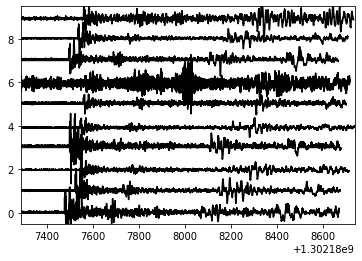

In [8]:
from mspasspy.ccore.seismic import TimeSeriesEnsemble
from mspasspy.graphics import SeismicPlotter
ensemble=TimeSeriesEnsemble()
query={ 'chan' : 'BHZ'}
n=db.wf_miniseed.count_documents(query)
print('Number of BHZ channels=',n)
print('Plotting only first 10')
curs=db.wf_miniseed.find(query).limit(10)
for doc in curs:
    # With the current mspass_lite schema these extra options are required
    d=db.read_data(doc,collection='wf_miniseed')
    ensemble.member.append(d)
plotter=SeismicPlotter(normalize=True)
plotter.change_style('wtva')
plotter.plot(ensemble)

One thing to note about the plot above is that the time scale is unix epoch time, but the matplotlib routines we use for the plotting convert that axis to a readable scale in seconds relative to the start time.  

### Metadata Association
#### Receiver Metadata
In a later section of this course we will go into more details about the database we use in MsPASS.  For the present the thing to recognize is that in the first few boxes of this notebook we downloaded source and receiver metadata and saved them to the database.   We also saved the waveform data in one of two methods, but in both cases the end result was a set of data stored as miniseed files.  A property of miniseed is that a unique channel is defined by five key attributes:  network code, station code, channel code, (when set) a location code, and a time stamp.   The miniseed data have absolutely no reference to what source we are examining. Anyone who has dealt with miniseed data knows it is can be a thorny problem to associate the right source and receiver metadata with each channel of data.  

We have a standard database method for associating channel metadata to data objects derived from miniseed files illustrated by the following script:

In [9]:
cursor=db.wf_miniseed.find({})
for doc in cursor:
    net=doc['net']
    sta=doc['sta']
    chan=doc['chan']
    wftime=doc['starttime']
    chandoc=db.get_seed_channel(net,sta,chan,time=wftime)
    sitedoc=db.get_seed_site(net,sta,time=wftime)
    chanid=chandoc['_id']
    siteid=sitedoc['_id']
    wfid=doc['_id']
    match={'_id' : wfid}
    updatedef={'$set' : {'channel_id' : chanid, 'site_id' : siteid}}
    db.wf_miniseed.update_one(match,updatedef)        
               

There are likely some pieces of the above that at this point you might view as an "incantation", but the key thing to notice are the calls to the database methods _get_seed_channel_ and _get_seed_site_.  Both return a special MongoDB thing called an "ObjectID" that we use extensively in MsPASS for cross-referencing.   The reason is the ObjectIDs involved always have an index defined and yield fast searches at the cost of being defined by a not so human friendly id value.  The script above finds unique records where station metadata are stored and sets an id field in each waveform.   The is done here through the low-level _update_one_ method for the database handle. The above works because of the special property of seed enforced by the FDSN that a channel of data can be uniquely identified by the five keys:  net, sta, chan, loc, and time.  We ignore loc above because we know that the TA did not use any loc codes.  

#### Source Metadata
The data we are working with here is a generalization of the seismic reflection processing idea of a "shot gather", meaning the data all come from a single earthquake with a common origin time.  Miniseed data have no concept of source metadata.  The general problem of linking source information to a given waveform has near infinite complexity, but for this first-order view of MsPASS the algorithm we need is pretty trivial; the complexity is only in the arcane syntax of MongoDB we need to make implement it: 

In [10]:
doc=db.source.find_one()
srcid=doc['_id']
cursor=db.wf_miniseed.find({})
for doc in cursor:
    wfid=doc['_id']
    db.wf_miniseed.update_one({'_id' : wfid},{'$set' : {'source_id' : srcid}})

To show that did something useful here we read back the first 6 waveforms and show how source and receiver data are stored in the generalized headers for these data:

In [11]:
db=Database(dbclient,'shortcourse')
cursor=db.wf_miniseed.find({}).limit(6)
print('net sta chan channel_lat channel_lon channel_elev source_lat source_lon source_depth source_time')
normalize_list=['source','channel']
for doc in cursor:
    d=db.read_data(doc,normalize=normalize_list,collection='wf_miniseed')
    print(d['net'],d['sta'],d['chan'],d['channel_lat'],d['channel_lon'],d['channel_elev'],
         d['source_lat'],d['source_lon'],d['source_depth'],UTCDateTime(d['source_time']))

net sta chan channel_lat channel_lon channel_elev source_lat source_lon source_depth source_time
TA TPFO BHE 33.605999 -116.454399 1.275 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA X39A BHE 34.510502 -94.1138 0.326 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA E26A BHZ 46.471199 -102.462097 0.806 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA C26A BHN 47.825901 -102.095703 0.656 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA O33A BHE 40.0755 -97.584503 0.48 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA E36A BHE 46.5177 -93.255699 0.393 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z


## Simple Serial Workflows
In section we illustrate some simple MsPASS workflows that use simple serlia processing driven by for loops.  In the main section following we will show a parallel version of the most elaborate serial workflow.
### Cut around P time
Our first example just reads the first 5 waveforms in the database, applies a simple filter, computes a theoretical P wave arrival time from the source and receiver metadata, windows the data relative to that P wave arrival time, and then plots the data.  

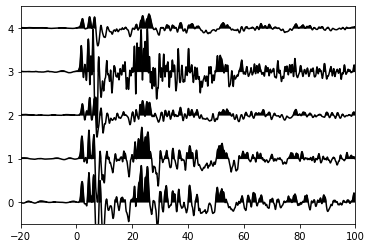

In [12]:
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import filter
from mspasspy.ccore.algorithms.basic import TimeWindow
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
# First we load all the data we want to work with into a single ensemble object
# limited to 5 here to keep the plot legible
ensemble=TimeSeriesEnsemble()
cursor=db.wf_miniseed.find({'chan' : 'BHZ'}).limit(5)
ensemble=db.read_ensemble_data(cursor,collection='wf_miniseed',normalize=normalize_list)

# This a time window in time relative to P arrival around 
# which we cut each waveform
cutwin=TimeWindow(-20.0,100.0)
i=0
for d in ensemble.member:
    filter(d,'bandpass',freqmax=2.0,freqmin=0.005)
    stalat=d['channel_lat']
    stalon=d['channel_lon']
    srclat=d['source_lat']
    srclon=d['source_lon']
    depth=d['source_depth']
    otime=d['source_time']
    georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
    # obspy's function we just called returns distance in m in element 0 of a tuple
    # their travel time calculator it is degrees so we need this conversion
    dist=kilometers2degrees(georesult[0]/1000.0)
    arrivals=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=dist,phase_list=['P'])
    # Arrivals are returned in time order 0 is always the first arrival
    # This computes arrival time as an epoch time and shifts the data to put 0 at that time
    d.ator(otime+arrivals[0].time)
    #d=WindowData(d,cutwin)
    ensemble.member[i]=WindowData(d,cutwin.start,cutwin.end)
    i+=1
plotter.plot(ensemble)

### Bundle into Seismogram objects
A novel feature of MsPASS is treating three-component data as a distinct data type.   The following box does that process to a subset of the entire data set.  We only do a subset of the data for two reasons.  (1) The default memory allocation in docker may cause problems on some machines if we used the algorithm below the full event gather.  (2)  An intentiona error allows us to illustrate another key feature of MsPASS.

In [13]:
from mspasspy.algorithms.bundle import bundle_seed_data
# This query causes the list of TimeSeries to be sorted by sta name
# We need that only because we are also limiting the number of data read
cursor=db.wf_miniseed.find({}).limit(10).sort('sta',1)
ensemble=db.read_ensemble_data(cursor,collection='wf_miniseed',normalize=normalize_list)
print('Ensemble size=',len(ensemble.member))
print('running bundle_seed_ensemble')
d3c=bundle_seed_data(ensemble)
print('Size of bundled ensemble=',len(d3c.member))

db.save_ensemble_data(d3c,data_tag='rawsample')

Ensemble size= 10
running bundle_seed_ensemble
Size of bundled ensemble= 4


Now if we are assembling bundles of 3 from a set of 10 TimeSeries what is the best that could happen?  We'd get 3 groups of 3 and one orphan.   Why did we get 4 bundles then?  This clarifies why as well as allowing me to use the best python joke ever!

In [14]:
from mspasspy.util.Undertaker import Undertaker
print('station status')
for d in d3c.member:
    print(d['sta'],d.live)
stedronsky=Undertaker(db)
[good_guys,zombies]=stedronsky.bring_out_your_dead(d3c)
print('\nThe undertaker found ',len(good_guys.member),
      ' data objects were marked live and ',len(zombies.member),' were marked dead\n')
print('Error log showing why datum was killed')
for i in range(len(zombies.member)):
    log=zombies.member[i].elog.get_error_log()
    for m in log:
        print(m.algorithm,m.message)

station status
109C False
035Z True
035A True
034A True

The undertaker found  3  data objects were marked live and  1  were marked dead

Error log showing why datum was killed
bundle_seed_data Insufficient data to generate Seismogram object.
Number of channels received  for bundling=1
Number marked live=1
Number live must be at least 3



This illustrates two important concepts used in MsPASS that you need to recognize:
1.   We borrow the ancient practice of marking data dead from from seismic reflection data processing. As we will see later that approach is critical for the parallel processing system to work cleanly.
2.   Errors are always something that have to be handled because only a trivial data set is clean enough to not generate one or more problems that have to be handled.  Again because of the parallel framework the cleanest way we found to handle this is to carry the errors along with the data with which that error is associated.   The *elog* symbol contains that error log in each data object.

### Database clean method
Converting data downloaded miniseed into these three component data objects creates a bunch of metadata inconsistencies.  In this case it is pervasive, but a whole range of things can create database inconsistencies a system like MsPASS needs to handled.   

To see the specific problem here let's just take a look at the metadata associated with the first 
seismogram.

In [15]:
from bson import json_util
n3c=db.wf_Seismogram.count_documents({})
print('Database current has ',n3c,' Seismogram objects')
doc=db.wf_Seismogram.find_one()
print(json_util.dumps(doc,indent=2))

Database current has  3  Seismogram objects
{
  "_id": {
    "$oid": "61030a2be19abb6bce009747"
  },
  "storage_mode": "gridfs",
  "dfile": "./wf/shortcourse_8.mseed",
  "last_packet_time": 1302188741.6499999,
  "time_standard": "UTC",
  "channel_elev": 0.019,
  "utc_convertible": true,
  "cardinal": false,
  "foff": 0,
  "npts": 55566,
  "dir": "/home/pavlis/tutorials/mspass_tutorial/sage-gage_2021",
  "nbytes": 65536,
  "orthogonal": false,
  "chan": "BHZ",
  "channel_edepth": 0.0,
  "site_id": {
    "$oid": "61030a21e19abb6bce008d28"
  },
  "channel_lon": -98.068298,
  "format": "mseed",
  "channel_id": {
    "$oid": "61030a21e19abb6bce008d2a"
  },
  "channel_endtime": 1321815600.0,
  "channel_starttime": 1262995200.0,
  "starttime": 1302187287.1,
  "tmatrix": [
    0.0,
    0.0,
    1.0,
    0.00872653549840032,
    0.9999619230641711,
    2.6484540326036093e-14,
    0.9999619230641713,
    -0.008726535498373787,
    2.6484540326036093e-14
  ],
  "sampling_rate": 40.0,
  "delta": 0

There are a number of attributes that are inconsistent with the data that are relics of single channel concepts, which we call TimeSeries data.   Examples are "chan" and several items with the structure "channel_X" where X is some suffix whose meaning you might guess (e.g. channel_lat is station latitude).  

We can fix these easily with a special method in the Database object we call clean_collection

In [16]:
db.clean_collection('wf_Seismogram',delete_undefined=True)
doc=db.wf_Seismogram.find_one()
print(json_util.dumps(doc,indent=2))

{
  "_id": {
    "$oid": "61030a2be19abb6bce009747"
  },
  "storage_mode": "gridfs",
  "dfile": "./wf/shortcourse_8.mseed",
  "time_standard": "UTC",
  "utc_convertible": true,
  "cardinal": false,
  "foff": 0,
  "npts": 55566,
  "dir": "/home/pavlis/tutorials/mspass_tutorial/sage-gage_2021",
  "orthogonal": false,
  "site_id": {
    "$oid": "61030a21e19abb6bce008d28"
  },
  "format": "mseed",
  "starttime": 1302187287.1,
  "tmatrix": [
    0.0,
    0.0,
    1.0,
    0.00872653549840032,
    0.9999619230641711,
    2.6484540326036093e-14,
    0.9999619230641713,
    -0.008726535498373787,
    2.6484540326036093e-14
  ],
  "sampling_rate": 40.0,
  "delta": 0.025,
  "source_id": {
    "$oid": "61030a1de19abb6bce008d21"
  },
  "gridfs_id": {
    "$oid": "61030a2ae19abb6bce009740"
  },
  "history_object_id": "2ac93bbc-2c1a-4176-bb83-08b9b501b85e"
}


Most of the relics are gone now, although there are a few that require a different approach to repair we will not inflict on you for now.   

The final point about data saved as *Seismogram* objectgs is they contain all the data and internal methods needed to handle any coordinate transformation. The next box illustrates this further:

transformation matrix defined in database
[0.0, 0.0, 1.0, 0.00872653549840032, 0.9999619230641711, 2.6484540326036093e-14, 0.9999619230641713, -0.008726535498373787, 2.6484540326036093e-14]


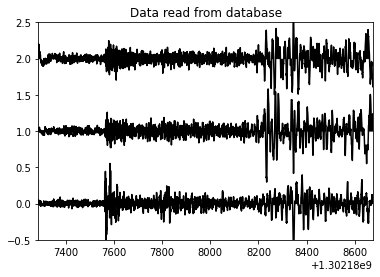

In [17]:
doc=db.wf_Seismogram.find_one()
print('transformation matrix defined in database')
print(doc['tmatrix'])
d=db.read_data(doc,collection='wf_Seismogram')
# this just makes the data look a little better
filter(d,'bandpass',freqmax=2.0,freqmin=0.01)
plotter.title='Data read from database'
plotter.plot(d)

What the printed output and the graphic show is that the data bundle assembled are not in cardinal directions (EW, NS, Z).  There are two reasons for that in this case:  (1) the TA measured orientations to high accuracy and the metadata told the system the measured orientations that were used to compute the transformation matrix, and (2) the bundle algorithm we ran didn't bother to try to assemble the components in any standard order.  We can regularize the data with a method in Seismogram used like this:

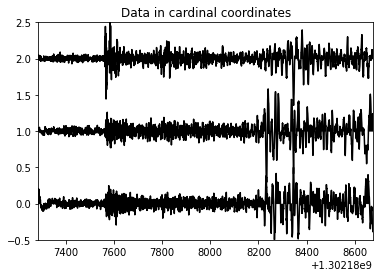

In [18]:
d.rotate_to_standard()
plotter.title='Data in cardinal coordinates'
plotter.plot(d)

Finally, we want to do some more things with Seismogram data in the next session.  What we did above was intentionally small to keep the output small.  Here we do the same process, but aim for 100 Seismogram objects in the read and add a line to save the result to the database.

In [19]:
cursor=db.wf_miniseed.find({}).limit(300).sort('sta',1)
ensemble=db.read_ensemble_data(cursor,collection='wf_miniseed',normalize=normalize_list)
print('Ensemble size=',len(ensemble.member))
d3c=bundle_seed_data(ensemble)
print('Size of bundled ensemble=',len(d3c.member))
db.save_ensemble_data(d3c,data_tag='rawdataset')

Ensemble size= 300
Size of bundled ensemble= 100


## Parallel Processing
Finally, a brief example of the parallel processing framework that is the last key component of MsPASS.  It is also the "P" in MsPASS.   The second day of this short course will focus on how all this works and scalability to HPC clusters or the cloud.   

For this overview there is one key concept you must grasp to understand the construct in the python code block below.   In serial processing like that we did above we treat individual data objects as the unit to be handled by an algorithm. We saw examples above of algorithms for TimeSeries, TimeSeriesEnsembles, Seismograms, and SeismogramEnsembles.   A key concept for the parallel framework in MsPASS is that we abstract a group of things that are all the same, which in MsPASS means TimeSeries, Seismogram, TimeSeriesEnsemble, or SeismogramEnsemble, as a unified data set.  Parallel schedulers we use, which are called Dask and Sparc, can parallelize a single function call that operates on a common data type with a simple variant of a standard python function call.   The best way to see this is to now run the following job on your desktop machine.  Start it and we'll discuss what is going on in the box below.

In [20]:
from mspasspy.algorithms.basic import rotate_to_standard
from mspasspy.db.database import read_distributed_data
n=db.wf_Seismogram.count_documents({})
print('number of input data to be processed=',n)
cursor=db.wf_Seismogram.find({})
dataset=read_distributed_data(db,cursor)
dataset=dataset.map(rotate_to_standard)
save_out=dataset.map(db.save_data,data_tag='dask_standardized')
dataset.compute()
print(save_out)


number of input data to be processed= 103
dask.bag<save_data, npartitions=103>


Note depending on your machine that job will take a while because it is effectively a serial job because the default docker container has only one "worker".  Let it run for now.  We will use these data later in the next section.   

There are three distinct steps here we want to discuss before the break.
1.  The call to *read_distributed_data* builds the container that defines the "data set".   Notice that it is driven by MongoDB "cursor" object created by the incantation sent to the find method of the Database object.  We will cover more on that shortly, but the idea is that cursor is a handle to all the database entries that define the "data set".   *read_distributed_data* translates the cursor into an abstraction of the entire data set, which in this case is 429 Seismogram objects. 
2. The only real processing step is the call to the function *rotate_to_standard*.   The is same method we used above to apply a transformation matrix to the three-component data to transform the data to standard geographic coordinates (x1=EW, x2=NS, and x3=Z).  Note the function call occurs inside a Dask construct of a "map" function.  We will revisit that idea multiple times on day 2, but for now think of it as a one-to-one application of function *rotate_to_standard* to each Seismogram in the data set.
3.  The map call to *db.save_data* is a parallel writer that saves each processed datum to the database with the "tag" of "dask_standardized".  